#                 Arrhythmia Beat Classification

## Step 0 : Lecture d'un enregistrement d'ECG 

Nous allons utiliser les donnees ecg du MIT que vous pouvez telecharger en suivant le liens : https://physionet.org/physiobank/database/mitdb/ 

                Importation des modules 
 Veuillez a telecharger tous les modules  surtout le premier avec 
                    **pip install wfdb**
                    et aussi le module tqdm
                    **pip install tqdm**

In [20]:
import wfdb as wf
import numpy as np
from matplotlib import pyplot as plt
import os
import h5py
import pandas as pd
from glob import glob
from scipy import signal as ss
from matplotlib import pyplot as plt

    Choisir le fichier a lire et a afficher dans un graphique 

In [2]:
FILE=1                # Il  y'a 48 fichier au total donc choisir entre 0 et 47 comme c'est dans une liste.
CHANNEL=0             # Il y a deux canaux
SAMPLE_START=114000   # Début de l'échantillon dans le fichier
SAMPLE_SIZE=4000      # Nombre de lectures (360 par seconde)

In [9]:
def get_records():
    """ 
    Recupere les chemins des donnees dans le dossier data/mitdb
    """

    if not os.path.isdir('data/mitdb'):
        print("veuillez telecharger les donnees mit dans lien donnees \
              \n Si deja fait les mettre dans un dossier mitdb qui est dans un dossier data")
        return 1 

    # Pour les donnees il ya trois extemsion pour chaque element .dat, .atr, .hea
    #Le module glob  trouve tous les  chemins correspondant au schema 
    #    specifie selon les regles utiliser par le Shell Unix
    paths = glob('data/mitdb/*.atr')

    # Se débarrasser de l'extension
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

In [4]:
# Get available data files by using the previous function get_record().
dbfiles = get_records()
print('Total files: ', len(dbfiles))

# Pick a file.
datfile = dbfiles[FILE]
print('Loading file:', datfile)

# Read the file.
record = wf.rdsamp(datfile)
annotation = wf.rdann(datfile, 'atr')

# Info about the data.
print('Sampling frequency:', record[1].get('fs'))
print('Data shape:', record[0].shape)
print('Annotations:', len(annotation.num))

Total files:  48
Loading file: data/mitdb/101
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 1874


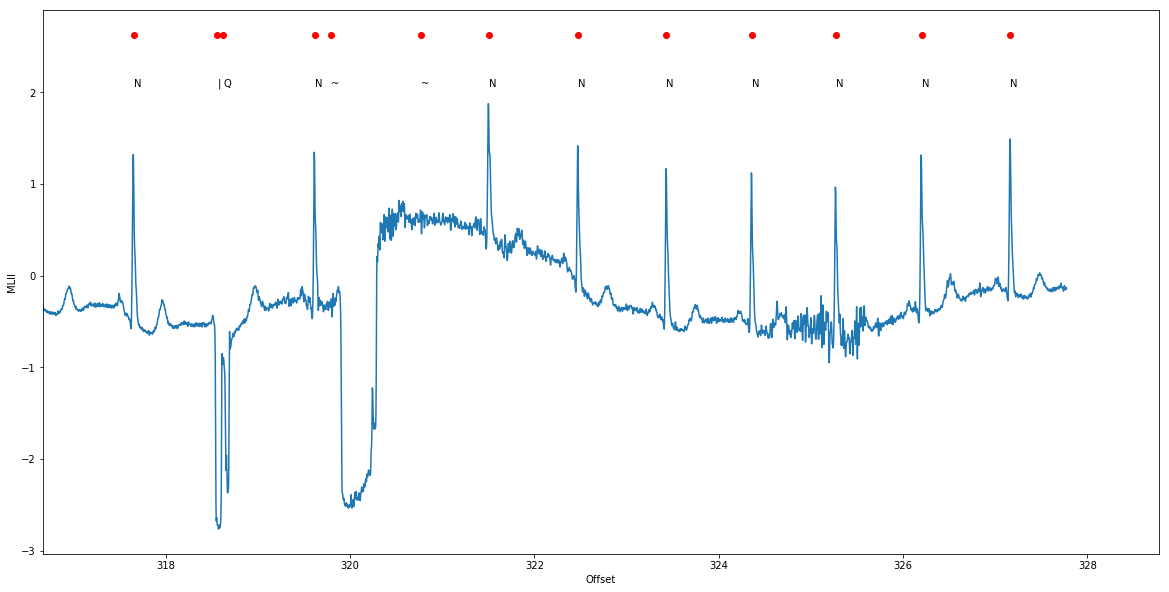

In [10]:
record = wf.rdsamp(datfile)
annotation = wf.rdann(datfile, 'atr')

# Recuperer des données et des annotations pour les échantillons sélectionnés ci-dessous.
sample_end = SAMPLE_START + SAMPLE_SIZE
channel = record[0][SAMPLE_START:sample_end, CHANNEL]

# Tracer du battement du coeur. L'échelle de temps est le nombre de lectures
# divided by sampling frequency.
times = (np.arange(SAMPLE_SIZE, dtype = 'float') + SAMPLE_START) / record[1].get('fs')
plt.figure(figsize=(20,10))
plt.plot(times, channel)

# EXtraire les annotations.
where = np.logical_and(annotation.sample >= SAMPLE_START, annotation.sample < sample_end)
annots = annotation.sample[where] - SAMPLE_START
annotypes = np.array(annotation.symbol)
annotypes = annotypes[where]

# Plot the Annotations.
annotimes = times[annots]
plt.plot(annotimes, np.ones_like(annotimes) * channel.max() * 1.4, 'ro')

# Code des Annotations .
for idx, annot in enumerate(annots):
    plt.annotate(annotypes[idx], xy = (times[annot], channel.max() * 1.1))

plt.xlim([SAMPLE_START / record[1].get('fs'), (sample_end / record[1].get('fs')) + 1])
plt.xlabel('Offset')
plt.ylabel(record[1].get('sig_name')[CHANNEL])
plt.show()

## Step 1 :  Segmentation des battements et la preparation des donnees 

### Convertir ensuite tous les fichiers en fichiers CSV portant le même nom (par exemple, à partir de 100.dat, 100.hea, 100.atr, le fichier 100.csv est généré).

    importation des modules

In [15]:
from scipy import signal
from biosppy.signals import ecg
from subprocess import call 

Au lieu d’utiliser les annotations pour trouver les temps, nous allons utilise la détection de pic R à la place. La raison en est que la même logique peut être utilisée pour analyser de nouvelles donnnes qui ne sont pas encore annotées.
Nous utilisons les annotations ici uniquement pour classer lesbat comme normal ou anormal et pour entraîner le modèle.

In [11]:
records = get_records()
print('Total files: ', len(records))

Total files:  48


In [12]:
# Reference:
# https://physionet.org/physiobank/database/html/mitdbdir/intro.htm
realbeats = ['N','L','R','B','A','a','J','S','V','r',
             'F','e','j','n','E','/','f','Q','?']

In [35]:
#creation du dossier devant contenir les fichiers csv cree
dirname = 'data_ecg'
if not dirname in os.listdir():
    os.makedirs(dirname)

In [13]:
# Boucle à travers chaque fichier d'entrée. Chaque fichier contient un
# enregistrement des lectures ECG, échantillonné à 360 lectures par seconde.

In [37]:
p = records[0]


In [ ]:
for path in records:
    pathpts = path.split('/')
    fn = pathpts[-1]
    print('Loading file:', path)

    # Lecture des donnees
    record = wf.rdsamp(path)
    annotation = wf.rdann(path, 'atr')

    # Information sur le signal qu'on extrait
    print('Sampling frequency used for this record:', record[1].get('fs'))
    print('Shape of loaded data array:', record[0].shape)
    print('Number of loaded annotations:', len(annotation.num))
    
    # Recuperer les valeurs de ECG depuis le fichiers
    data = record[0].transpose()

    # Generer la classfication basee dans les annotation .
    # 0.0 = undetermined
    # 1.0 = normal
    # 2.0 = abnormal
    cat = np.array(annotation.symbol)
    rate = np.zeros_like(cat, dtype='float')
    for catid, catval in enumerate(cat):
        if (catval == 'N'):
            rate[catid] = 1.0 # Normal
        elif (catval in realbeats):
            rate[catid] = 2.0 # Abnormal
    rates = np.zeros_like(data[0], dtype='float')
    rates[annotation.sample] = rate
    
    indices = np.arange(data[0].size, dtype='int')

    # Traitez chaque canal séparément (2 par fichier d’entrée).
    for channelid, channel in enumerate(data):
        chname = record[1].get('sig_name')[channelid]
        print('ECG channel type:', chname)
        
        # Trouver les  R_peaks dans les donnees the ECG . La plupart devraient correspondre aux annotations.
        out = ecg.ecg(signal=channel, sampling_rate=360, show=False)
        rpeaks = np.zeros_like(channel, dtype='float')
        rpeaks[out['rpeaks']] = 1.0
        
        beatstoremove = np.array([0])

        # Diviser en battements de coeur individuels.
        #Pour chaque battement de coeur enregistre, ajouter la classification (normal/abnormal).
        beats = np.split(channel, out['rpeaks'])
        for idx, idxval in enumerate(out['rpeaks']):
            firstround = idx == 0
            lastround = idx == len(beats) - 1

            # Passer le premier et le dernier battement.
            if (firstround or lastround):
                continue

            # Obtenir la valeur de classification qui est sur ou près de la position de l'index de réponse.
            fromidx = 0 if idxval < 10 else idxval - 10
            toidx = idxval + 10
            catval = rates[fromidx:toidx].max()
            
            # Ignorer les temps s'il n'y a pas de classement.
            if (catval == 0.0):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            # Le temps normal est maintenant classé comme 0.0 et anormal est 1.0.
            catval = catval - 1.0

            # Append some extra readings from next beat.
            beats[idx] = np.append(beats[idx], beats[idx+1][:40])

            # Normalize the readings to a 0-1 range for ML purposes.
            beats[idx] = (beats[idx] - beats[idx].min()) / beats[idx].ptp()

            # Resample from 360Hz to 125Hz
            newsize = int((beats[idx].size * 125 / 360) + 0.5)
            beats[idx] = signal.resample(beats[idx], newsize)

            # Annuler les enregistrement superieur a 187.
            if (beats[idx].size > 187):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            # Remplir avec des 0 si la tailles est inferieur a 187 .
            zerocount = 187 - beats[idx].size
            beats[idx] = np.pad(beats[idx], (0, zerocount), 'constant', constant_values=(0.0, 0.0))

            # Ajouter la classification dans le battemenet de la donnees.
            beats[idx] = np.append(beats[idx], catval)

        beatstoremove = np.append(beatstoremove, len(beats)-1)

        # Supprimez les premier et dernier battements et ceux sans classification.
        beats = np.delete(beats, beatstoremove)

        # Save to CSV file.            
        os.chdir(dirname)    
        savedata = np.array(list(beats[:]), dtype=np.float)
        outfn = fn+'_'+chname+'.csv'
        #creation du fichier
        call('touch ' + outfn, shell=True)
        print('Generating ', outfn)
        with open(outfn, "wb") as fin:
            np.savetxt(fin, savedata, delimiter=",", fmt='%f')
        os.chdir('..')

###  Affichage d'un enregistrement dernierement creer en fichier csv 

In [33]:
data = np.loadtxt('data_ecg/210_MLII.csv', delimiter=',')
print(data.shape)

(2444, 188)


In [50]:
data[2][187]

0.0

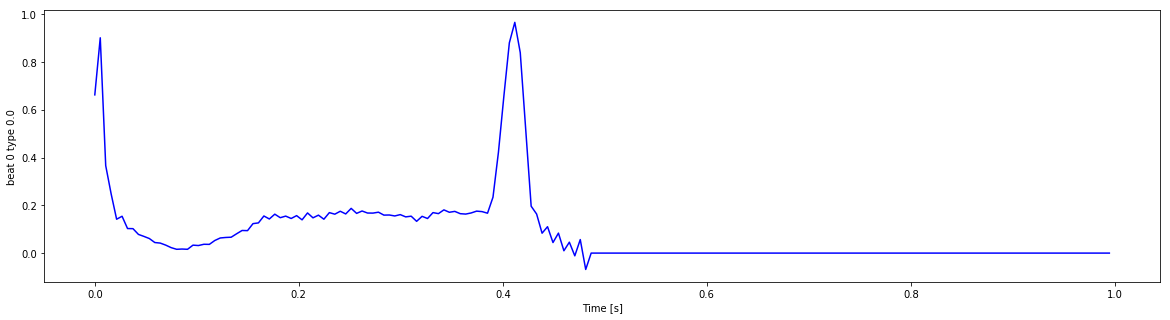

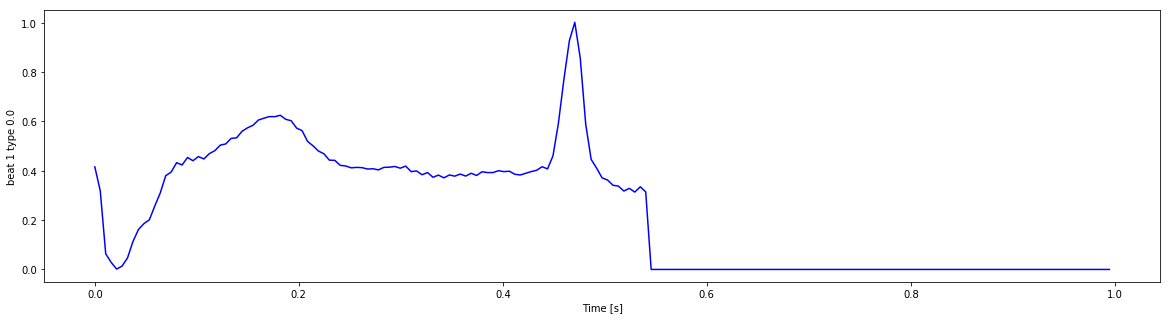

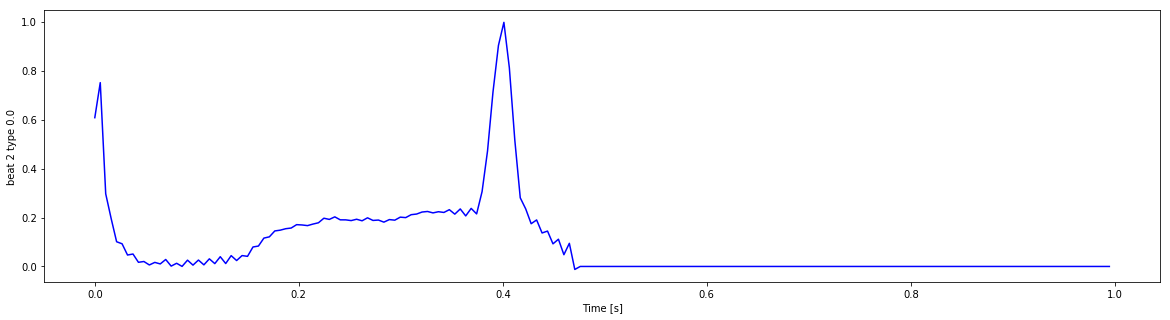

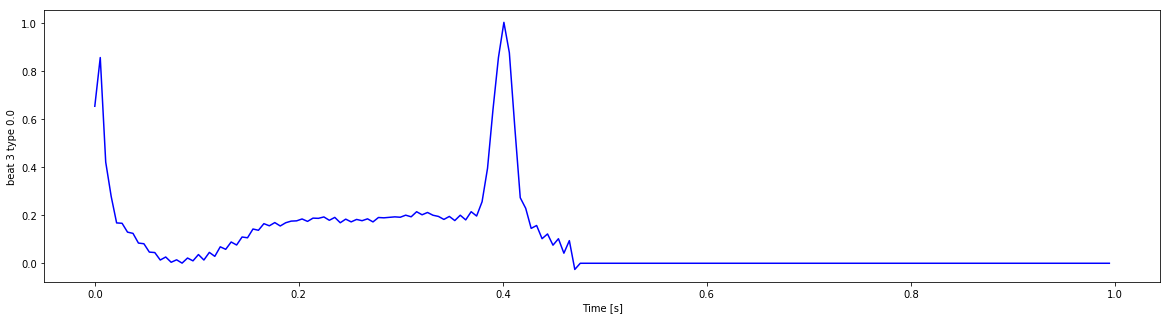

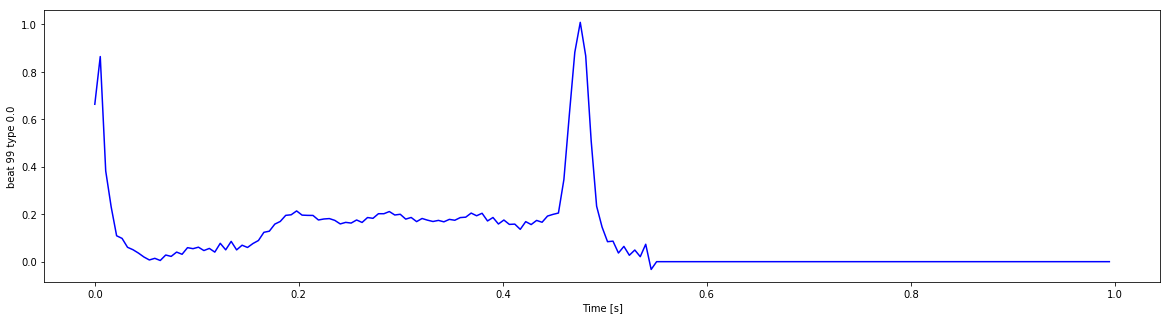

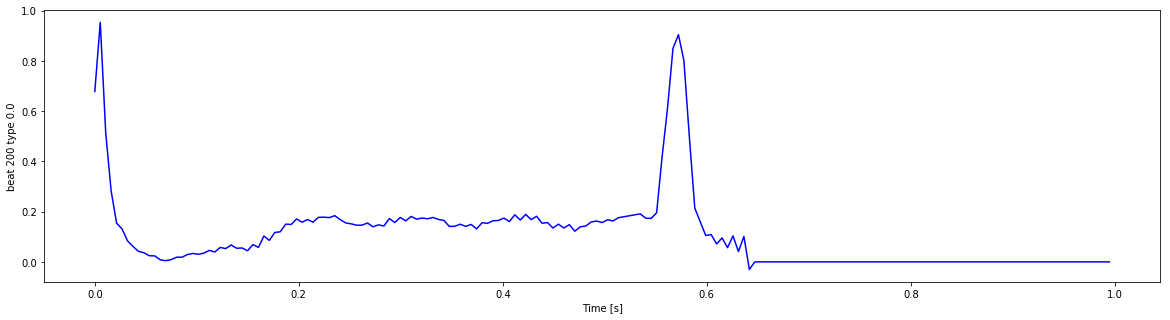

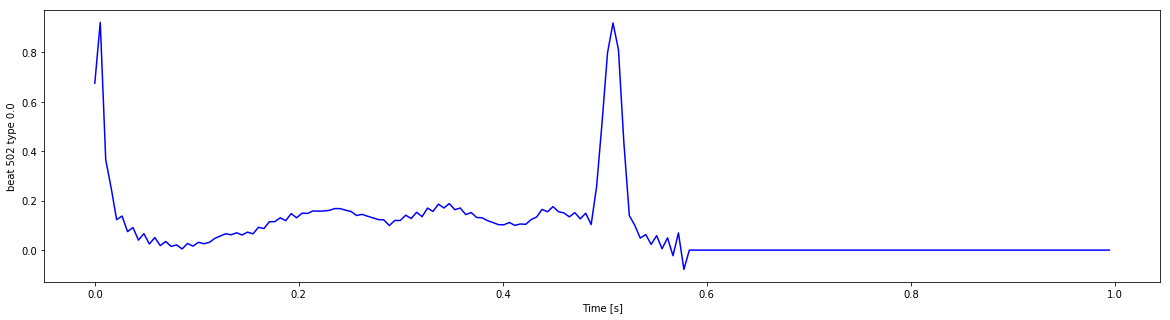

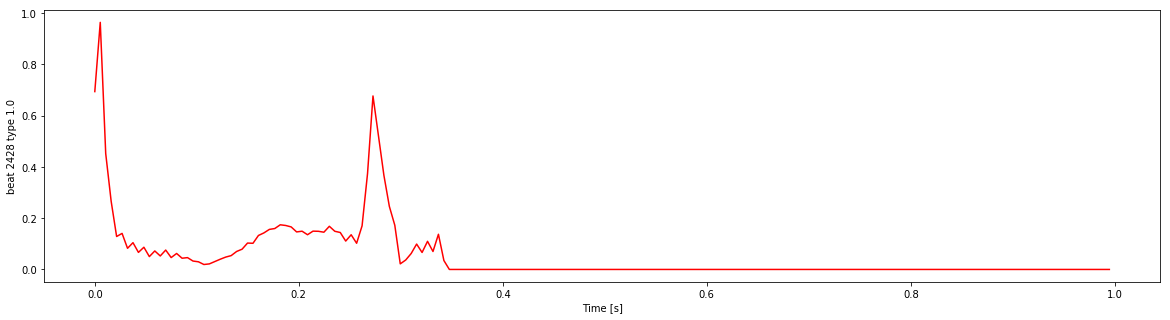

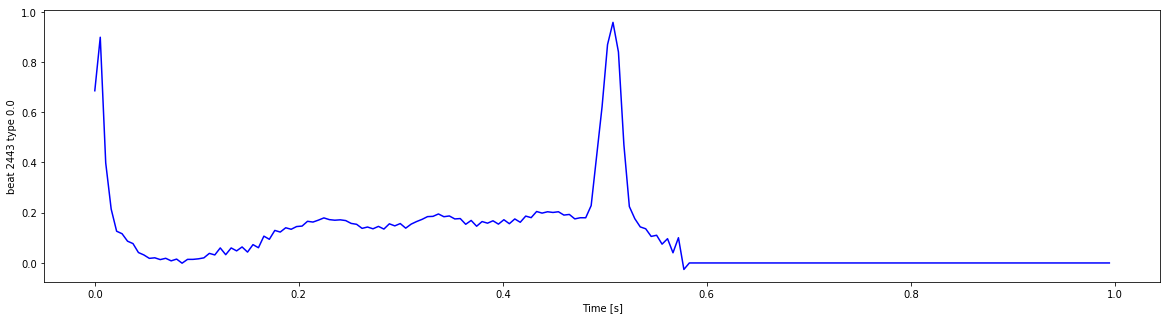

In [34]:
for beatid in [0,1,2,3,99,200,502,2428,2443]:
    times = np.arange(187, dtype = 'float') / 187
    beat = data[beatid][:-1]
    anno = data[beatid][-1]
    plt.figure(figsize=(20,5))
    if (anno == 0.0):
      plt.plot(times, beat, 'b')
    else:
      plt.plot(times, beat, 'r')
    plt.xlabel('Time [s]')
    plt.ylabel('beat ' + str(beatid) + " type " + str(anno))
    plt.show()

### Preparation des donnees csv en les departageant en donnnes d'entrainement, de teste,et de validation

In [51]:
alldata = np.empty(shape=[0, 188])
print(alldata.shape)
paths = glob('data_ecg/*.csv')
for path in paths:
    print('Loading ', path)
    csvrows = np.loadtxt(path, delimiter=',')
    alldata = np.append(alldata, csvrows, axis=0)

(0, 188)
Loading  data_ecg/122_V1.csv
Loading  data_ecg/234_MLII.csv
Loading  data_ecg/212_V1.csv
Loading  data_ecg/106_V1.csv
Loading  data_ecg/124_V4.csv
Loading  data_ecg/116_V1.csv
Loading  data_ecg/214_V1.csv
Loading  data_ecg/232_V1.csv
Loading  data_ecg/220_MLII.csv
Loading  data_ecg/108_MLII.csv
Loading  data_ecg/104_V2.csv
Loading  data_ecg/119_MLII.csv
Loading  data_ecg/223_MLII.csv
Loading  data_ecg/214_MLII.csv
Loading  data_ecg/208_V1.csv
Loading  data_ecg/107_V1.csv
Loading  data_ecg/121_MLII.csv
Loading  data_ecg/117_MLII.csv
Loading  data_ecg/207_V1.csv
Loading  data_ecg/219_MLII.csv
Loading  data_ecg/201_MLII.csv
Loading  data_ecg/221_V1.csv
Loading  data_ecg/228_V1.csv
Loading  data_ecg/103_V2.csv
Loading  data_ecg/228_MLII.csv
Loading  data_ecg/115_V1.csv
Loading  data_ecg/222_MLII.csv
Loading  data_ecg/102_V2.csv
Loading  data_ecg/111_V1.csv
Loading  data_ecg/105_V1.csv
Loading  data_ecg/108_V1.csv
Loading  data_ecg/210_MLII.csv
Loading  data_ecg/118_MLII.csv
Loadin

In [52]:
alldata.shape

(149358, 188)

In [54]:
#melanger les donnees et les separer en donnnes entrainement test et de validation
np.random.shuffle(alldata)
totrows = len(alldata)
trainrows = int((totrows * 3 / 5) + 0.5) # 60%
testrows = int((totrows * 1 / 5) + 0.5) # 20%
validaterows = totrows - trainrows - testrows # 20%
mark1 = trainrows
mark2 = mark1 + testrows

In [55]:
with open('train.csv', "wb") as fin:
    np.savetxt(fin, alldata[:mark1], delimiter=",", fmt='%f')

In [57]:
with open('test.csv', "wb") as fin:
    np.savetxt(fin, alldata[mark1:mark2], delimiter=",", fmt='%f')

In [58]:
with open('validate.csv', "wb") as fin:
    np.savetxt(fin, alldata[mark2:], delimiter=",", fmt='%f')

In [59]:
ls

'Arrhythmia Beat Classification.ipynb'   data_ecg/   train.csv
 data/                                   test.csv    validate.csv
